In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score



In [3]:
df = pd.read_csv('./dataset.csv')
df.columns = [ i.replace(' ','_').lower().strip() for i in df.columns]

In [4]:
# hay 1 projecto con `project_priority` = np.nan, drop it.
df = df[df['project_priority'].notnull()]

# Usamos solo los proyectos finalizados
df = df[df['state'] == '(3) Closed']


##### Feature Engineering

In [5]:
df['project_priority'] = df['project_priority'].apply(lambda x: int(x.split(')')[0].replace('(','')))

# Imputamos la feature `tota_headcount` & `num_tasks` con la mediana.
df['total_headcount'] = df['total_headcount'].fillna(df['total_headcount'].median())
df['num_tasks'] = df['num_tasks'].fillna(df['num_tasks'].median())

# Limpiamos la variable para volverla `float`
for i in ['avg_risk_exposure']:
    df[i] = df[i].apply(lambda x: x.replace(',','.'))
    df[i]  = df[i].astype(float)

In [6]:
k_means_columns = ['project_priority','avg_risk_exposure','total_headcount','num_tasks','duration']

#### Train - Test Split, 70/30

In [7]:
X = df[k_means_columns] 
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

### PCA

In [8]:
preprocessing_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))  
])

In [9]:
# Pipeline en Train (Fit & Transform)
X_train_pca = preprocessing_pipeline.fit_transform(X_train)


# Pipeline en Test (Transform)
X_test_pca = preprocessing_pipeline.transform(X_test)

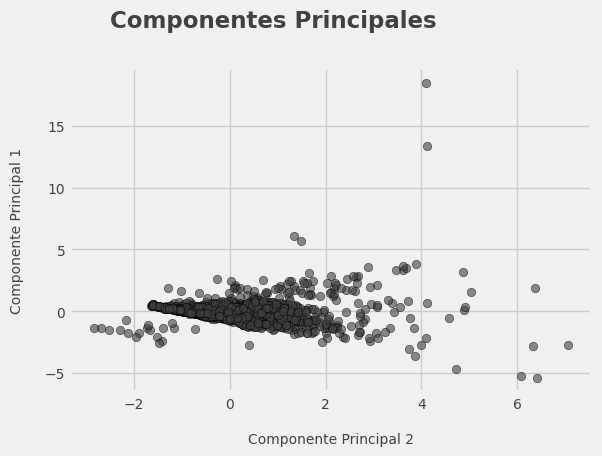

In [10]:
plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.6, edgecolor='k', color = '#414141')

plt.ylabel('Componente Principal 1', fontsize = 10, color = '#414141',labelpad = 15)
plt.xlabel('Componente Principal 2', fontsize = 10, color = '#414141',labelpad = 15)

plt.yticks( fontsize = 10, color = '#414141');
plt.xticks( fontsize = 10, color = '#414141');


plt.text(x=-2.5, y=23, s = "Componentes Principales", fontsize = 16.5, fontweight = 'bold', color = '#414141');

plt.show()

In [11]:
pca_object = preprocessing_pipeline.named_steps['pca']

varianza_explicada, total_varianza = pca_object.explained_variance_ratio_, np.sum(pca_object.explained_variance_ratio_)
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(varianza_explicada))],
    'Varianza Explicada': varianza_explicada
})

print(f'Explained variance by PC1: {varianza_explicada[0]:.2%}')
print(f'Explained variance by PC2: {varianza_explicada[1]:.2%}')
print(f'Explained variance : {round(total_varianza * 100,2)}%')


Explained variance by PC1: 28.14%
Explained variance by PC2: 20.32%
Explained variance : 48.46%


#### K-Means with K=2

In [12]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

labels = kmeans.labels_

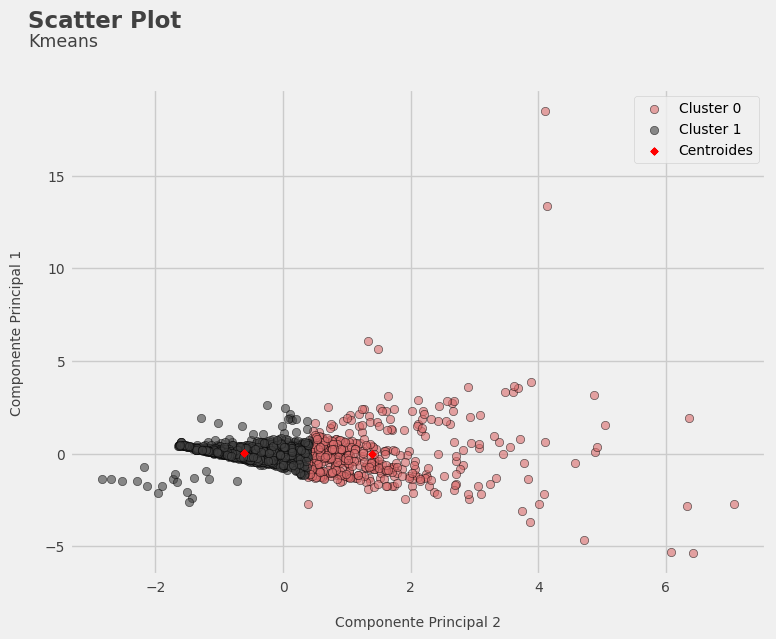

In [13]:
colores = ['#DA6C6C', '#414141'] 

plt.figure(figsize=(8, 6))

for cluster in range(2):
    plt.scatter(
        X_train_pca[labels == cluster, 0],
        X_train_pca[labels == cluster, 1],
        color=colores[cluster],
        alpha=0.6,
        edgecolor='k',
        label=f'Cluster {cluster}'
    )


centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=10, marker='x', label='Centroides')


plt.text(x=-4., y=23, s = "Scatter Plot", fontsize = 16.5, fontweight = 'bold', color = '#414141')
plt.text(x=-4., y=22, s = "Kmeans", fontsize = 12.5, color = '#414141')

plt.ylabel('Componente Principal 1', fontsize=10, color='#414141', labelpad=15)
plt.xlabel('Componente Principal 2', fontsize=10, color='#414141', labelpad=15)

plt.yticks(fontsize=10, color='#414141')
plt.xticks(fontsize=10, color='#414141')

plt.legend(loc = 'upper right',fancybox = True, fontsize = 10)

plt.grid(True)
plt.show()


In [14]:
sil_score = silhouette_score(X_train_pca, labels)
db_index = davies_bouldin_score(X_train_pca, labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

Silhouette Score: 0.4833
Davies-Bouldin Index: 0.9968


In [15]:
X_train['Kmeans_labels'] = labels

In [17]:
X_train.groupby(['Kmeans_labels']).describe().to_clipboard()